#cambio y aplicar cambios en VM

# Título  gbtd con envío sin reentrenar
## Autor: Jose Chelquer
## Fecha de última modificación: 24/11/2024

Carga el modelo optimizado, evalúa y envía



## Parámetros

< Descripción de cada uno de los parámetros que utiliza el job >


In [241]:
experimento="sp__"                        # sampleado, preprocesado feat simple
tipo_registros=experimento[0]            # '_'completo s sampleado
con_preprocesamiento = experimento[1]    # p con preprocesamiento  '_' sin preprocesamiento
tipo_featuring=experimento[2]            # _: 155 base  s: simple    c: completo
rf=experimento[3]                        # _: sin RF   r: con RF

dict_tipo_registros={'_': 'completo', 's': 'sampleado'}
dict_con_preprocesamiento={'_': 'sin preprocesamiento', 'p':'con preprocesamiento'}
dict_tipo_featuring={'_': 'base', 's':' simple', 'c': 'completo'}
dict_rf={'_': 'sin RF', 'f':' con RF'}

print (f'Experimento {experimento}')
print (dict_tipo_registros[tipo_registros])
print (dict_con_preprocesamiento[con_preprocesamiento])
print (dict_tipo_featuring[tipo_featuring])
print (dict_rf[rf])


Experimento sp__
sampleado
con preprocesamiento
base
sin RF


In [242]:
# vm o local?
vm=True
if vm:
  usar_gdrive=False
else:
  usar_gdrive=True      #se va a usar google dirve


In [243]:
semillas=[101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197]

ganancia_acierto=273000
costo_estimulo=7000

In [244]:
# meses de entrenamiento, evaluación y test
if vm:
  mes_train_desde = 202101
  mes_train_hasta = 202105
  mes_eval=202106
  mes_test = 202108
else:
  mes_train_desde = 202104
  mes_train_hasta = 202105
  mes_eval=202106
  mes_test = 202108

In [245]:
params_file="best_params.json"

In [246]:

grabar_importancias=False          # Se puede pedir que grabe las importancias de variables como resultado secundario
importancias_file=f'importancias_lgb{experimento}.csv.gz'


In [247]:
# parámetros de envío a kaggle
version = f'210_{experimento}_'
prefijo_envio=f"j010_lgb_{experimento}_"
enviar_desde=7000
enviar_hasta=16000
cant_envios=10            #Cantidad de envíos a Kaggle

# para prueba
#enviar_desde=12000
#enviar_hasta=12000
#cant_envios=2            #Cantidad de envíos a Kaggle


## Input

< Archivos de datos (csv.gz) con sus paths que van a consumirse por el job>

In [248]:
if vm:
  dataset_path = '/home/jose/buckets/b1/datasets'
  kaggle_json_path="/home/jose/buckets/b1"
  dataset_file=f"k2_{tipo_registros}{con_preprocesamiento}{tipo_featuring}{rf}.parquet.gz"
else:
  dataset_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/datasets/'
  kaggle_json_path="/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas"

  sufijo=''
  if dset=="rf":
    sufijo='_cRF'
  infijo='_base'
  if feat=="aum":
    infijo='_aum'

  dataset_file=f"sample_c02{infijo}_m1a8{sufijo}.csv.gz"

print (dataset_path)
print (dataset_file)

/home/jose/buckets/b1/datasets
k2_sp__.parquet.gz


In [249]:
if vm:
  db_path='/home/jose/buckets/b1/db'
  modelos_path='/home/jose/buckets/b1/modelos'

else:
  db_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/db/'
        # optuna no puede hacerlo en drive.  La copia se hará al final, si se puede
  modelos_path='/content/drive/MyDrive/Data Science y similares/Maestría Data Mining Exactas/dmeyf/dmeyf2024/modelos/'

modelos_file=f'lgb_optimizado_{experimento}'
print (f'Se va a usar el modelo {modelos_file}')
import os
path_modelo=os.path.join(modelos_path, modelos_file)+".txt"
print (f'Path del modelo: {path_modelo}')
print ('-------------------------------')
print ('controlar que sea el optimizado')
print ('-------------------------------')


Se va a usar el modelo lgb_optimizado_sp__
Path del modelo: /home/jose/buckets/b1/modelos/lgb_optimizado_sp__.txt
-------------------------------
controlar que sea el optimizado
-------------------------------


## Output

< Archivos, bases de datos, modelos que va a generar el job>

## Procesos

### Paquetes necesarios

## Código del proceso

< Todo el código a partir de aquí debe poder ejecutarse sin necesidad de parametrizar nada>

Instalamos, cargamos y seteamos el entorno

## Gdrive?

In [250]:
if usar_gdrive:
  from google.colab import drive
  drive.mount('/content/drive')

## Librerías

In [251]:
!pip install --upgrade pip
!pip install --upgrade lightgbm
!pip install dask[dataframe]

In [252]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import shutil

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer


import json

from time import time

import pickle



In [253]:
import lightgbm as lgb

## Funciones útiles varias

In [254]:
def buscar_columnas(data, texto):
    # devuelve los nombre de cols de data que contengan texto
    # Encuentra las columnas que contienen el texto
    columnas_filtradas = [col for col in data.columns if texto in col]
    
    # Imprime las columnas que coinciden
    return columnas_filtradas

## Leer datos

In [255]:
semilla=semillas[2]


In [256]:
def contabilizar(df, descripción):
  print (f'\nContabilización de la base {descripción}\n')
  print (f'\nShape: {df.shape}\n')
  n_vars=len(df.columns)
  n_vars_tree=len([col for col in df.columns if col.startswith('tree')])
  print (f"Variables: {n_vars}")
  print (f"Variables tree: {n_vars_tree}")
  print (f"\nFilas por mes: \n{df['foto_mes'].value_counts()}\n")
  if 'clase_ternaria' in df.columns:
    print (f"\nFilas por mes y clase: \n{pd.crosstab(df['foto_mes'], df['clase_ternaria'])}\n")
def cant_meses(df):
  return len(df['foto_mes'].unique())

In [257]:
if 'parquet' in dataset_file:
    data = pd.read_parquet(os.path.join(dataset_path, dataset_file))
else:
    data = pd.read_csv(os.path.join(dataset_path, dataset_file))
if 'clase_ternaria_num' in data.columns:
  data = data.drop(columns=['clase_ternaria_num'])

In [258]:
data = data.sort_values(by=['foto_mes', 'numero_de_cliente'])


In [259]:
data.loc[data['foto_mes']==mes_test, 'numero_de_cliente'].head(10)

209867    249221109
209868    249221468
209869    249223005
209870    249228180
209871    249232117
209872    249236712
209873    249236857
209874    249237079
209875    249237446
209876    249239632
Name: numero_de_cliente, dtype: int64

In [260]:

contabilizar(data, 'Datos Leídos '+ dataset_file)


Contabilización de la base Datos Leídos k2_sp__.parquet.gz


Shape: (375309, 155)

Variables: 155
Variables tree: 0

Filas por mes: 
foto_mes
202108    165442
202104     18363
202105     18352
202106     18271
202103     18169
202102     17886
202101     17481
202012     17307
202011     17097
202010     16921
202009     16771
202007     16629
202008     16620
Name: count, dtype: int64


Filas por mes y clase: 
clase_ternaria  BAJA+1  BAJA+2  CONTINUA
foto_mes                                
202007             627     542     15460
202008             544     472     15604
202009             474     564     15733
202010             565     488     15868
202011             490     646     15961
202012             649     634     16024
202101             635     785     16061
202102             785    1017     16084
202103            1020     981     16168
202104             982    1189     16192
202105            1189     911     16252
202106             908    1074     16289
202108    

# ------------------------------------------------------------------
# Eliminado aquí a último momento para probar
# ------------------------------------------------------------------


In [261]:
columnas_comisiones = buscar_columnas(data, 'comis')
columnas_finic=buscar_columnas(data, 'finic')
columnas_avg=buscar_columnas(data, 'avg')
columnas_ratio=buscar_columnas(data, 'ratio')
columnas_tree=buscar_columnas(data, 'tree')
columnas_lag=buscar_columnas(data, 'lag')


#columnas_a_eliminar=columnas_comisiones+columnas_finic+columnas_avg
columnas_a_eliminar=(columnas_comisiones
                     )
columnas_a_eliminar=[]

data = data.drop(columns=columnas_a_eliminar)
print (f"Nueva cantidad de columnas {len(data.columns)}")

Nueva cantidad de columnas 155


In [262]:
# FIN DEL AGREGADO DE ULTIMO MOMENTO

Vamos a asignar pesos a las clases. En unos minutos explicaremos las razones detrás de esta decisión. Mientras tanto, pueden aprovechar el código para ajustar el peso de la clase **BAJA+2** según lo deseen.


## Recodificar clase ternaria

In [263]:
data['clase_peso'] = 1.0

data.loc[data['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
data.loc[data['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [264]:
data['clase_binaria1'] = 0
data['clase_binaria2'] = 0
data['clase_binaria1'] = np.where(data['clase_ternaria'] == 'BAJA+2', 1, 0)
data['clase_binaria2'] = np.where(data['clase_ternaria'] == 'CONTINUA', 0, 1)

Y trabajaremos como es habitual en las últimas clases, con **Febrero** para entrenar y **Abril** para medir, con el fin de realizar *backtesting*

## Preparar train y test

In [265]:
test_data = data[data['foto_mes'] == mes_test]
eval_data = data[data['foto_mes'] == mes_eval]

print ("Armando X_eval")
X_eval = eval_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)
y_eval_binaria1 = eval_data['clase_binaria1']
y_eval_binaria2 = eval_data['clase_binaria2']
w_eval = test_data['clase_peso']

print ("Armando X_test")
X_test = test_data.drop(['clase_ternaria', 'clase_peso', 'clase_binaria1','clase_binaria2'], axis=1)

print ("listo")

contabilizar(X_eval, 'datos de evaluación')
contabilizar(X_test, 'datos de test')


Armando X_eval
Armando X_test
listo

Contabilización de la base datos de evaluación


Shape: (18271, 154)

Variables: 154
Variables tree: 0

Filas por mes: 
foto_mes
202106    18271
Name: count, dtype: int64


Contabilización de la base datos de test


Shape: (165442, 154)

Variables: 154
Variables tree: 0

Filas por mes: 
foto_mes
202108    165442
Name: count, dtype: int64



In [266]:
# Para calcular ganancias fuera del proceso de optimización:
def ganancias_obtenidas(y_pred, X, weight):
    n_meses=cant_meses(X)
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
    ganancia = ganancia[np.argsort(y_pred)[::-1]] #: desde todo : hasta todo :-1 step hacia atrás
    # Ganancias acumuladas so far
    print (ganancia)
    
    ganancia_acum = np.cumsum(ganancia)
    print (ganancia_acum)
    ganancia_maxima=max(ganancia_acum)
    cant_envios = np.argmax(ganancia_acum) + 1  # Sumar 1 para tener la posición en términos de "cantidad"

    return np.round(ganancia_acum/n_meses/1000), np.round(ganancia_maxima/n_meses/1000), cant_envios



## Recuperación de best params

In [267]:
# Entreno con el mejor modelo
# Ruta al archivo JSON con los mejores parámetros
input_path = os.path.join(modelos_path, params_file)

# Cargar los parámetros desde el archivo
with open(input_path, "r") as file:
    best_params = json.load(file)

print("Parámetros cargados:", best_params)



Parámetros cargados: {'num_leaves': 367, 'learning_rate': 0.21973326885018724, 'min_data_in_leaf': 81, 'feature_fraction': 0.6762459148093933, 'bagging_fraction': 0.49690708220730284}


## Cargar el modelo

In [268]:
print (path_modelo)
model = lgb.Booster(model_file=os.path.join(modelos_path, modelos_file)+'.txt')

/home/jose/buckets/b1/modelos/lgb_optimizado_sp__.txt


# Resultados de entrenamiento

In [269]:
y_pred_eval=model.predict(X_eval)

ganancias_eval, gmax_eval, envios_eval=ganancias_obtenidas(y_pred_eval, X_eval, w_eval)
print (f"Ganancia máxima en eval: {gmax_eval}\n")
print (f"Envíos para ganancia máxima: {envios_eval}\n")
print (f"Ganancias en eval: {ganancias_eval}")

[-7000 -7000 -7000 ... -7000 -7000 -7000]
[     -7000     -14000     -21000 ... -127883000 -127890000 -127897000]
Ganancia máxima en eval: -7.0

Envíos para ganancia máxima: 1

Ganancias en eval: [-7.00000e+00 -1.40000e+01 -2.10000e+01 ... -1.27883e+05 -1.27890e+05
 -1.27897e+05]


In [270]:
def resultados_modelo(model, feature_names):
  importances = model.feature_importance()
  importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
  importance_df = importance_df.sort_values('importance', ascending=False)
  importance_df[importance_df['importance'] > 0]

  print(importance_df.head(20))

  if grabar_importancias:
      if importancias_file.endswith('.gz'):
        importance_df.to_csv(os.path.join(dataset_path,  importancias_file), index=False, compression='gzip')
      else:
        importance_df.to_csv(os.path.join(dataset_path,  importancias_file), index=False)
resultados_modelo(model, X_test.columns.tolist())

                         feature  importance
5                   cliente_edad        3520
0              numero_de_cliente        3015
8           mrentabilidad_annual        2916
6             cliente_antiguedad        2767
107                 ctrx_quarter        2485
16             mcuenta_corriente        2424
113          Master_Fvencimiento        2372
22                mcuentas_saldo        2356
135            Visa_Fvencimiento        2318
11               mpasivos_margen        2177
149               Visa_fechaalta        2147
7                  mrentabilidad        2129
127             Master_fechaalta        2036
10               mactivos_margen        2019
18                  mcaja_ahorro        1927
112  Master_mfinanciacion_limite        1894
97    chomebanking_transacciones        1698
134    Visa_mfinanciacion_limite        1622
9                    mcomisiones        1433
147             Visa_mpagospesos        1429


In [271]:
print (y_pred_eval)

[3.62656824e-05 6.19818288e-04 5.14967985e-06 ... 2.96542320e-06
 8.00049786e-06 1.93969745e-04]


## Para Kaggle



In [272]:
def enviar_kaggle(y_pred_test, X_test):
  # Cargo el kaggle.json para poder conectarme
  # Mueve kaggle.json al directorio correcto
 if not vm:
      os.makedirs('/root/.kaggle', exist_ok=True)
      shutil.copy(f'{kaggle_json_path}/kaggle.json', '/root/.kaggle/kaggle.json')
      os.chmod('/root/.kaggle/kaggle.json', 600)
  # Obtengo el orden de prioridad para el envío
    
 idx_deseables=np.argsort(y_pred_test)[::-1]
    # ------------------------------------------------------------------
  # Los topes de envíos se determinaron al hacer la curva en eval
 for envios in np.linspace(enviar_desde, enviar_hasta, cant_envios, dtype=int):
      print (f"Enviando: {envios}")
      # Notar que idx_deseables tiene índices de y_pred (de 0 al máximo de línes de y_pred)

      # los primeros envíos irán con predicción 1 y el resto 0
      # idx_deseables contiene los índices de y_pred (no los originales!!) cuyas predicciones tienen los mejores valores, en orden desdendente
      # guardo en elegidos los índices de los datos correspondientes a los primeros :envios en idx
      elegidos=X_test.index[idx_deseables[:envios]]

      # Creo clientes_kaggle sólo con el número de cliente de  X_test
      clientes_kaggle=X_test.loc[:, ['numero_de_cliente']].copy()
      clientes_kaggle['Predicted']=0    #default
      clientes_kaggle.loc[elegidos, 'Predicted'] = 1   # marco los "enviados"

      if clientes_kaggle.shape != ( 165442, 2):
        raise ValueError(f"El DataFrame 'clientes_enviados' no tiene la forma esperada. Forma actual: {clientes_kaggle.shape}")
      else:
        print("La forma de 'clientes_enviados' es correcta.")

      # elijo el nombre para el archivo enviar, para llevar control
      # un mensaje para registrar
      # y me grabo el archivo que mando para tener control local

      # Voy a mandar con un mensaje que incluya los parámetros usados y la cantidad de envíos
      mensaje=f"lgbm aumentada semillero {best_params} {envios}"
      # # Me gusta guardar los envíos que hago
      archivo=f'{prefijo_envio}-v_{version}-{envios}.csv'
      import os 
      path_archivo=os.path.join(dataset_path,archivo)
      clientes_kaggle.to_csv(path_archivo, index=False)

      # Envío a la competencia
      competencia="dm-ey-f-2024-segunda"
      !kaggle competitions submit -c {competencia} -f '{path_archivo}' -m '{mensaje}'

 params_str = str(best_params)

 # Eliminar llaves {}, apóstrofes ' y dos puntos :
 params_str = params_str.replace('{', '').replace('}', '').replace("'", '').replace(':', '').replace(",",'')
 print (params_str)

 print (clientes_kaggle)



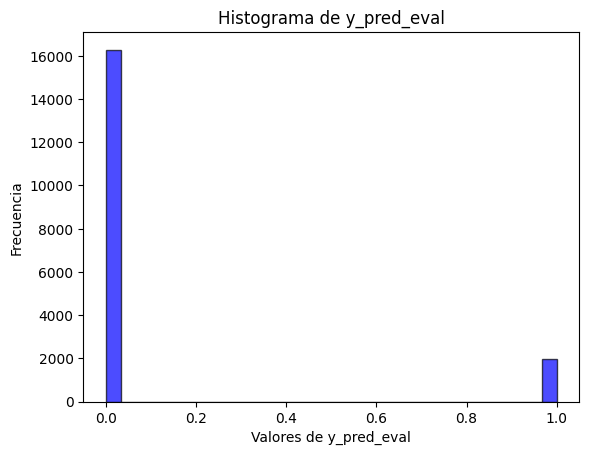

In [273]:
# Suponiendo que y_pred_eval es un array o lista
plt.hist(y_pred_eval, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histograma de y_pred_eval')
plt.xlabel('Valores de y_pred_eval')
plt.ylabel('Frecuencia')
plt.show()

In [274]:
y_pred_test=model.predict(X_test)

In [275]:
np.sort(y_pred_test)[::-1]
#y_pred_test

array([9.99998493e-01, 9.99997615e-01, 9.99996707e-01, ...,
       2.99912975e-11, 2.55094741e-11, 1.86494134e-11])

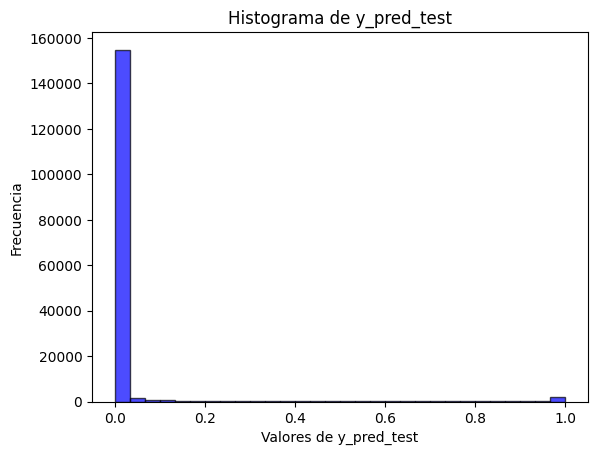

In [276]:
# Suponiendo que y_pred_eval es un array o lista
plt.hist(y_pred_test, bins=30, color='blue', edgecolor='black', alpha=0.7)
plt.title('Histograma de y_pred_test')
plt.xlabel('Valores de y_pred_test')
plt.ylabel('Frecuencia')
plt.show()

# ENVIO A KAGGLE

In [277]:
enviar_kaggle(y_pred_test, X_test)

Enviando: 7000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.93M/1.93M [00:00<00:00, 3.08MB/s]
Successfully submitted to DMEyF 2024 SegundaEnviando: 8000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.93M/1.93M [00:00<00:00, 3.21MB/s]
Successfully submitted to DMEyF 2024 SegundaEnviando: 9000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.93M/1.93M [00:00<00:00, 3.28MB/s]
Successfully submitted to DMEyF 2024 SegundaEnviando: 10000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.93M/1.93M [00:00<00:00, 3.29MB/s]
Successfully submitted to DMEyF 2024 SegundaEnviando: 11000
La forma de 'clientes_enviados' es correcta.
100%|██████████████████████████████████████| 1.93M/1.93M [00:00<00:00, 2.96MB/s]
Successfully submitted to DMEyF 2024 SegundaEnviando: 12000
La forma de 'clientes_enviados' es correcta.
100%|███████